In [3]:
print('A')

A


In [ ]:
import pandas as pd
import os

folder_path = r'C:\Users\RISHI RAMAN\Desktop\vis\unifedmentor\Projects-20240722T093004Z-001\fraud_detection\data'

dfs = []  

for file in os.listdir(folder_path):
    if file.endswith('.pkl'):
        full_path = os.path.join(folder_path, file)
        df = pd.read_pickle(full_path) 
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.head())
print("Shape of combined DataFrame:", combined_df.shape)


   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      64.49   
4               4 2018-04-01 00:10:34         927        9906      50.99   

  TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0              31            0         0                  0  
1             130            0         0                  0  
2             476            0         0                  0  
3             569            0         0                  0  
4             634            0         0                  0  
Shape of combined DataFrame: (1754155, 9)


In [62]:
X['TX_TIME_SECONDS'] = pd.to_numeric(X['TX_TIME_SECONDS'], errors='coerce')
X['TX_TIME_DAYS'] = pd.to_numeric(X['TX_TIME_DAYS'], errors='coerce')
X['TX_TIME_SECONDS'] = X['TX_TIME_SECONDS'].astype('category')
X['TX_TIME_DAYS'] = X['TX_TIME_DAYS'].astype('category')



## feature enginerring + weight

In [75]:
combined_df['TX_DATETIME'] = pd.to_datetime(combined_df['TX_DATETIME'])

combined_df['HOUR'] = combined_df['TX_DATETIME'].dt.hour
combined_df['DAY_OF_WEEK'] = combined_df['TX_DATETIME'].dt.dayofweek
combined_df['WEEKEND'] = combined_df['DAY_OF_WEEK'].isin([5, 6]).astype(int)


In [76]:
# Number of transactions by customer and terminal (helps identify high activity)
combined_df['CUSTOMER_TX_COUNT'] = combined_df.groupby('CUSTOMER_ID')['CUSTOMER_ID'].transform('count')
combined_df['TERMINAL_TX_COUNT'] = combined_df.groupby('TERMINAL_ID')['TERMINAL_ID'].transform('count')


In [77]:
# Deviation from customer's typical behavior
customer_avg = combined_df.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('mean')
combined_df['TX_AMOUNT_DEV'] = combined_df['TX_AMOUNT'] / (customer_avg + 1e-6)


In [78]:
features = [
    'TX_AMOUNT',
    'TX_TIME_SECONDS',
    'TX_TIME_DAYS',
    'CUSTOMER_TX_COUNT',
    'TERMINAL_TX_COUNT',
    'TX_AMOUNT_DEV',
    'HOUR',
    'DAY_OF_WEEK',
    'WEEKEND'
]
target = 'TX_FRAUD'


In [79]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [45]:
X = combined_df[features]
y = combined_df[target]

# Train-test split, stratify to keep fraud distribution consistent
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Optional: scaling features (XGBoost doesn't require it, but can help)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)

# Define XGBoost model with imbalance-aware parameters
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=200,  # handle class imbalance
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
X_train.info()
# Train model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

[[-0.05348308  1.34324564  1.34404434 ... -0.09909938 -1.50295149
  -0.6390031 ]
 [-0.85802355  0.0345054   0.03820747 ... -0.89012331 -1.00486345
  -0.6390031 ]
 [-0.23723615 -1.36577561 -1.36225527 ... -0.89012331  0.48940066
  -0.6390031 ]
 ...
 [ 0.99606148 -1.3049474  -1.30547975 ...  0.09865661 -1.50295149
  -0.6390031 ]
 [-0.92873419 -0.05540462 -0.05641839 ...  0.29641259 -0.00868738
  -0.6390031 ]
 [ 0.35422643 -0.77734804 -0.77557493 ... -0.49461135 -1.50295149
  -0.6390031 ]]
<class 'pandas.core.frame.DataFrame'>
Index: 1403324 entries, 1556862 to 483524
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   TX_AMOUNT          1403324 non-null  float64
 1   TX_TIME_SECONDS    1403324 non-null  int64  
 2   TX_TIME_DAYS       1403324 non-null  int64  
 3   CUSTOMER_TX_COUNT  1403324 non-null  int64  
 4   TERMINAL_TX_COUNT  1403324 non-null  int64  
 5   TX_AMOUNT_DEV      1403324 non-null  floa

c:\Users\RISHI RAMAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[244719 103176]
 [   622   2314]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9975    0.7034    0.8250    347895
           1     0.0219    0.7881    0.0427      2936

    accuracy                         0.7041    350831
   macro avg     0.5097    0.7458    0.4339    350831
weighted avg     0.9893    0.7041    0.8185    350831

ROC AUC Score: 0.8396


In [81]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. Convert problematic columns before selecting features
combined_df["TX_TIME_SECONDS"] = pd.to_numeric(combined_df["TX_TIME_SECONDS"], errors='coerce')
combined_df["TX_TIME_DAYS"] = pd.to_numeric(combined_df["TX_TIME_DAYS"], errors='coerce')

# 2. Select features and target
X = combined_df[features]
y = combined_df[target]

# 3. Handle any missing values caused by coercion
X = X.fillna(0)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Define the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# 6. Train the model
model.fit(X_train, y_train)

# 7. Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 8. Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


c:\Users\RISHI RAMAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:31:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[347612    283]
 [  2215    721]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9937    0.9992    0.9964    347895
           1     0.7181    0.2456    0.3660      2936

    accuracy                         0.9929    350831
   macro avg     0.8559    0.6224    0.6812    350831
weighted avg     0.9914    0.9929    0.9911    350831

F1 Score: 0.3660
ROC AUC Score: 0.7970


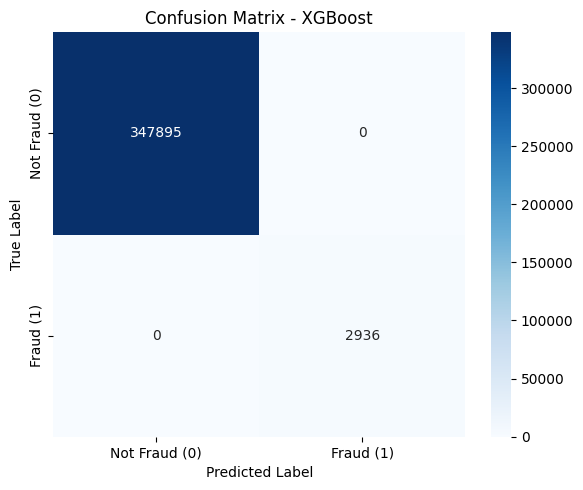

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict again if needed
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Fraud (0)', 'Fraud (1)']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

# 1. Extract features and target
X = combined_df[features]
y = combined_df[target]

# 2. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Handle imbalance with scale_pos_weight (no resampling)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 5. Train XGBoost
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    # scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)

# 6. Evaluate on test set
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


c:\Users\RISHI RAMAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:44:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[347536    359]
 [  2367    569]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9932    0.9990    0.9961    347895
           1     0.6131    0.1938    0.2945      2936

    accuracy                         0.9922    350831
   macro avg     0.8032    0.5964    0.6453    350831
weighted avg     0.9901    0.9922    0.9902    350831

ROC AUC Score: 0.7756


## sampling methods